# Project Description and goals 
In this months Tabular Playground we have a synthetic [forest cover dataset ](https://www.kaggle.com/c/forest-cover-type-prediction/data). 

My initial process should be as follows: 
* Quick EDA - null values, duplicates, correlation, redundant feature analysis 
* Feature Engineering - can we create futher features?

In this notebook we will try to create a full pipeline as opposed to [last months notbook ](https://www.kaggle.com/slythe/tabular-playground-competition-nov-2021) where we seperated each step \
**Pipeline process:**
* Scaling & splitting 
* Base model testing (trees, linear, ANN) 
* Model optimization 

Scoring = accuracy

# Libraries 

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import classification_report, accuracy_score

#scaling 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

#models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import lightgbm as lgb

# EDA 

In [ ]:
train = pd.read_csv("../input/tabular-playground-series-dec-2021/train.csv", index_col=0)
test = pd.read_csv("../input/tabular-playground-series-dec-2021/test.csv", index_col=0)

In [ ]:
train.shape

In [ ]:
train.sample(10)

In [ ]:
train.info()

In [ ]:
train["Cover_Type"].value_counts()

In [ ]:
plt.figure(figsize = (10,7))
sns.countplot(x = train["Cover_Type"])
plt.title("Count of Target (Cover_Type)")

### PCA analysis 
Due to the large number of features, creating pairplots or jointplots would not be feasible to analyse  

We however can decompose our features into 2 features using principal Component Analysis

In [ ]:
pca = PCA(n_components=2,whiten=True)
train_pca = pca.fit_transform(train.drop("Cover_Type",axis =1))

In [ ]:
df_pca = pd.DataFrame(train_pca, columns = ["pca_1","pca_2"])
df_pca["Target"] = train["Cover_Type"]

In [ ]:
df_pca.info()

In [ ]:
"""plt.figure(figsize = (15,10))
sns.lmplot(data = df_pca, x = "pca_1", y = "pca_2", hue= "Target")"""

In [ ]:
"""sns.boxplot(data = df_pca)"""

**Note**: Large number of outliers, scaling might improve our scoring 

### Correlation analaysis 
We will exclude soil types as these are boolean values 

In [ ]:
cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Cover_Type']

In [ ]:
plt.figure(figsize = (15,10))
sns.heatmap(train[cols].corr(), vmin = -1, vmax=1, annot = True, cmap="Spectral") 

**Note**: Elevation seems to have the highest negative correlation to Cover_type although relativelty weak correlation 

## Split

In [ ]:
X = train.drop("Cover_Type",axis =1)
y = train["Cover_Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Quick Model - logistic Regression
We will use a linear model as our baseline and test the two scaler types: 
* Standard Scaler 
* Robust Scaler 

In [ ]:
def model_scoring(model, scaling):
    pipe = Pipeline(steps = [ 
        ("scaler", scaling),
        ("model",model)
    ])
    
    pipe.fit(X_train,y_train)
    print("model score:",pipe.score(X_test,y_test))

    y_pred= pipe.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return pipe

In [ ]:
#reg_model = model_scoring(LogisticRegression(solver = "sag") ,RobustScaler() )

In [ ]:
#reg_model = model_scoring(LogisticRegression(solver = "sag") ,StandardScaler() )

**Note**  Standardscaler and Robust scaler dont seem to make a difference

# Class Imbalance 
### Class 5 is missing from the classification report above! 
Class 5 only has one observation, which is not ideal. In a normal circumstances we would need to add more samples of Class 5 \
Which is available in the [original data ](https://www.kaggle.com/c/forest-cover-type-prediction) \
However Kaggle doesnt allow us to submit with another dataset 

Im adverse to drop data so we shall keep it 

Also due to imbalanced dataset, **accuracy** is usually a poort metric so we will use another (f1_weighted?) 

# Feature Engineering and splitting 
I took alot of points from the below notebook all credit to GULSHAN MISHRA 

https://www.kaggle.com/gulshanmishra/tps-dec-21-tensorflow-nn-feature-engineering/notebook

In [ ]:
# Aspect changes as this in in degrees - negative isnt neccesary
train["Aspect"][train["Aspect"] < 0] += 360
train["Aspect"][train["Aspect"] > 359] -= 360

test["Aspect"][test["Aspect"] < 0] += 360
test["Aspect"][test["Aspect"] > 359] -= 360

In [ ]:
# Distance 

# Manhhattan distance to Hydrology
train["manhattan_dist_hydrology"] = np.abs(train["Horizontal_Distance_To_Hydrology"]) + np.abs(train["Vertical_Distance_To_Hydrology"])
test["manhattan_dist_hydrology"] = np.abs(test["Horizontal_Distance_To_Hydrology"]) + np.abs(test["Vertical_Distance_To_Hydrology"])

# Euclidean distance to Hydrology
train["euclidean_dist_hydrology"] = (train["Horizontal_Distance_To_Hydrology"]**2 + train["Vertical_Distance_To_Hydrology"]**2)**0.5
test["euclidean_dist_hydrology"] = (test["Horizontal_Distance_To_Hydrology"]**2 + test["Vertical_Distance_To_Hydrology"]**2)**0.5

As per discussion 
https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/292823

In [ ]:
## create column of count of soil types, and wilderness types
soil_features = [x for x in train.columns if x.startswith("Soil_Type")]
train["soil_type_count"] = train[soil_features].sum(axis=1)
test["soil_type_count"] = test[soil_features].sum(axis=1)

wilderness_features = [x for x in train.columns if x.startswith("Wilderness_Area")]
train["wilderness_area_count"] = train[wilderness_features].sum(axis=1)
test["wilderness_area_count"] = test[wilderness_features].sum(axis=1)

In [ ]:
for x in train.columns:
    if "Soil" in x:
        if train[x].nunique() ==1:
            print(x,train[x].nunique())
    else:
        pass

In [ ]:
#drop Soil_Type7 and Soil_Type7 as they only have 1 value

train.drop(["Soil_Type7","Soil_Type15"],axis = 1, inplace= True )
test.drop(["Soil_Type7","Soil_Type15"],axis = 1, inplace= True )

In [ ]:
train.tail(5)

# Downcasting 
We note from train.info above that all columns are int64 \
We should look at the min and max of the columns to check if they need full 64bit to store the integers 

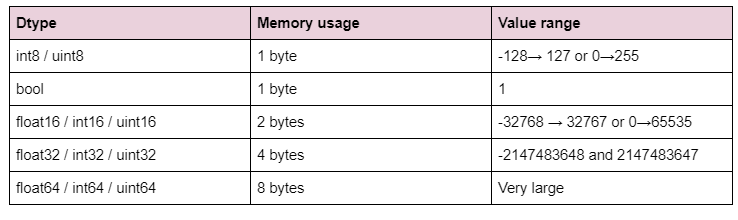

In [ ]:
#memory before
train.info(memory_usage="deep", max_cols=1)

In [ ]:
#memory before
test.info(memory_usage="deep", max_cols=1)

In [ ]:
for col in train.columns:
    print(f"{col} min = {min(train[col])}, max = {max(train[col])}")

In [ ]:
for col in train.columns:
    if train[col].dtype == "float64":
        train[col]=pd.to_numeric(train[col], downcast="float")
    if train[col].dtype == "int64":
        train[col]=pd.to_numeric(train[col], downcast="integer")
        
for col in test.columns:
    if test[col].dtype =="float64":
        test[col] = pd.to_numeric(test[col], downcast="float")
    if test[col].dtype =="int64":
        test[col] = pd.to_numeric(test[col], downcast="integer")

In [ ]:
train.info(memory_usage="deep", max_cols=1)

In [ ]:
test.info(memory_usage="deep", max_cols=1)

## Re-Split
With new features

In [ ]:
X = train.drop("Cover_Type",axis =1)
y = train["Cover_Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling

In [ ]:
std_scaler = StandardScaler()
min_scaler = MinMaxScaler()   # for Multinomial bayes - cant use negative values 

In [ ]:
std_scaler.fit(X_train)
X_train= std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)

In [ ]:
min_scaler.fit(X_train)
X_train_mm= min_scaler.transform(X_train)
X_test_mm = min_scaler.transform(X_test)

## Evaluation of Base models (cross validation scoring)

In [ ]:
"""
# prepare models
models = []
models.append(('LR', LogisticRegression(solver = "sag", max_iter= 300 )))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('LightXGB', lgb.LGBMClassifier()))
models.append(('RF', RandomForestClassifier(max_depth= 10)))
models.append(('Ber', BernoulliNB()))
#models.append(('SVM', LinearSVC(max_iter = 3000)))

# evaluate models
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = StratifiedKFold(n_splits=3)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
"""

In [ ]:
"""
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()"""

# GridSearchCV
Using the best model above we will try difference parameters

In [ ]:
lgb_params = {
    'model__boosting_type': ["dart"],
    'model__n_estimators': [400],
    "model__learning_rate": [0.01],
    'model__num_leaves': [200],
    'model__max_depth':[11]
                   }

In [ ]:
kfold = StratifiedKFold(n_splits= 5, shuffle=True , random_state= 42)

In [ ]:
def grid_scoring(model, params ):
    
    pipe = Pipeline(steps = [ 
        ("scaler", RobustScaler()),
        ("model",model)
    ])
    
    grid = GridSearchCV(estimator=pipe,
                param_grid=params,
                scoring = "accuracy",
                cv = kfold)
    
    grid.fit(X_train,y_train)
    
    print("Best score: ", grid.best_score_)
    print("Best params: ",grid.best_params_)
    
    y_pred= grid.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return grid

In [ ]:
lgb_model = grid_scoring(lgb.LGBMClassifier(), lgb_params)

In [ ]:
lgb_model.plot_importance()

# Submission

In [ ]:
s_test = std_scaler.transform(test)

In [ ]:
test_pred = lgb_model.predict(s_test)

sub = pd.DataFrame(test_pred, columns=["Cover_Type"])
sub.set_index(test.index,inplace=True)

sub.to_csv("submission.csv")